# Predict shift using Resnet18 and regression network
## Zhongyi Jiang
Given two images (input and reference), find the shift between these two images.


In [1]:
from skimage import io
from skimage import color
from skimage import exposure
from skimage import transform
from skimage.segmentation import flood, flood_fill
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import skimage as ski
from skimage import io, transform


In [ ]:
import csv
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import sys
sys.path.insert(1, '../../utils')
from utils import RegistrationDatasetLoader
import torchvision.models as models

In [ ]:
dtype = torch.float32 ## instialize the data types used in training
my_device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")

## Loading dataset

In [ ]:
TrainingSet = RegistrationDatasetLoader(csv_file='TrainingDatasetClassification.csv')#, root_dir_input='', root_dir_ref='./TranslationDataset/Train/reference')
TestingSet  = RegistrationDatasetLoader(csv_file='TestingDatasetClassification.csv' )#,root_dir_input='./TranslationDataset/Test/input', root_dir_ref='./TranslationDataset/Test/reference')

## Batch Size is a hyper parameter, You may need to play with this paramter to get a more better network
## This is a user controlled parameter you can change this value


BatchSize = 8

train_loader = DataLoader( TrainingSet  , batch_size=BatchSize,  num_workers=1)
test_loader  = DataLoader( TestingSet    , batch_size=1,  num_workers=1)

## Check accuracy function
This function will test the model on the test dataset. The accuracy return a percentage. Input error represents for the pixel toleration in the shift result comparsion.

In [ ]:
def checkTestingAccuracy(dataloader,model1,model2,my_device,error):
    ## This Function Checks Accuracy on Testing Dataset for the model passed
    ## This function should return the loss the Testing Dataset

    ## Before running on Testing Dataset the model should be in Evaluation Mode    
    model1.eval()
    model2.eval()
    totalscore = []
    index = 1
    for t, temp in enumerate(dataloader):
        input_image = temp['inputImage'].to(device=my_device,dtype=dtype)
        refer_image = temp['ref_image'].to(device=my_device,dtype=dtype)
        x_shift = temp['x-shift'].to(device=my_device,dtype=dtype)
        y_shift = temp['y-shift'].to(device=my_device,dtype=dtype)
        y_label = torch.stack((x_shift,y_shift),1)
        
        ## Forward pass
        inputs = model1(input_image)
        refers = model1(refer_image)
        middle_layer = torch.cat((inputs,refers),1)             
        output = model2(middle_layer) #output size batch*2
        
        diff = output-y_label
        # ignore the minor shift due to number precision
        diff[diff<error]=0
        diff = diff.flatten()
        index+=2
        if diff[0]==0 and diff[1]==0: # both coordinate are correct
            totalscore.append(1)
        elif diff[0]!=0 and diff[1]!=0: # None of the coordinate is correct
            totalscore.append(0)     
        else: # one of the coordinate is correct
            totalscore.append(0.5)
        
    return sum(totalscore)/len(totalscore)*100
        ## ************ End of your code ********************   ##

In [ ]:
import copy
def trainingLoop(dataloader,model,model2,optimizer2,nepochs,my_device):
    ## This function Trains your model for 'nepochs'
    ## Using optimizer and model your passed as arguments
    ## On the data present in the DataLoader class passed
    ##
    ## This function return the final loss values
    
    model = model.to(device=my_device) # resnet model    
    model2 = model2.to(device=my_device)
    
    full_loss=[]
    
    ## Our Loss function for this exercise is fixed to MSELoss
    loss_function = nn.MSELoss()
    for e in range(nepochs):
            full_loss=[]
            for t, temp in enumerate(dataloader):
                ## Before Training Starts, put model2 in Training Mode
                model2.train()
                torch.cuda.empty_cache()
                
                input_image = temp['inputImage'].to(device=my_device,dtype=dtype)
                refer_image = temp['ref_image'].to(device=my_device,dtype=dtype)
                x_shift = temp['x-shift'].to(device=my_device,dtype=dtype)
                y_shift = temp['y-shift'].to(device=my_device,dtype=dtype)
                y_label = torch.stack((x_shift,y_shift),1) # y label size batch*2
                
                
                ## Forward pass
                inputs = model(input_image) # batchsize * A * M * M
                refers = model(refer_image) # batchsize * A * M * M
                
                middle_layer = torch.cat((inputs,refers),1)  # batchsize * 2A * M * M
                output = model2(middle_layer) # batchsize * 2
                
                
                # Calculate loss
                loss = loss_function(output, y_label)
            
                ## Set Gradients to Zero
                optimizer2.zero_grad()
                
                ## Backward pass
                loss.backward()
            
                ## Optimizer Step
                optimizer2.step()
                
                ## Add it up the Loss
                full_loss.append(loss.item())
            best_trained_model=copy.deepcopy(model2.state_dict())
            torch.save(best_trained_model,'./best_trained_model2+.pt')
            print("Epoch ",e,": ",sum(full_loss)/len(full_loss))
    return best_trained_model,loss_array

## Model define


- The model is made of two part: Resnet18 and a fully connect layer. The Resnet18 will extract the features from two images and merge them into a single tensor. Then the fully connected layer will flatten the array and do a linear combination. We got 2 numbers correspondded with x shift and y shift. The loss function is MSE loss. A total epochs of 100 was trained and the loss dropped from 500 to 4~5. 

In [ ]:
# Regression network
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device=my_device)

# This is the backbone part
model1 = nn.Sequential(
    resnet18.conv1,
    resnet18.bn1,
    resnet18.relu,
    resnet18.maxpool,
    resnet18.layer1,
    resnet18.layer2,
    resnet18.layer3,   
) 
model2 = nn.Sequential(
    nn.BatchNorm2d(512),
    nn.Conv2d(512, 256, (5,5), padding=2),
    nn.ReLU(),
    nn.Conv2d(256, 128, (3,3), padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    
    nn.Conv2d(128, 64, (5,5), padding=2),
    nn.ReLU(),
    nn.Conv2d(64, 32, (3,3), padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(4),
    
    nn.Conv2d(32, 64, (5,5), padding=2),
    nn.ReLU(),
    nn.Conv2d(64, 128, (3,3), padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Flatten(),
    nn.Linear(2048, 2),
)

## Set your hypter parameters
learning_rate = 1e-3
weight_decay  = 1e-3
epochs =50

# A total of 100 epochs were trained

## Optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)

In [ ]:
'''
best_model1 = model1.cuda()
best_model1.load_state_dict(torch.load('./best_trained_model_1+.pt'))
best_model1.eval()
'''
best_model2 = model2.cuda()
best_model2.load_state_dict(torch.load('./best_trained_model2+.pt'))
best_model2.eval()

# total epoch 100
best_model,loss_array = trainingLoop(train_loader,model1,best_model2,optimizer2,epochs,my_device)

Epoch  0 :  7.19121208522507
Epoch  1 :  6.631590263225113
Epoch  2 :  7.12541606666285
Epoch  3 :  6.727601472784228
Epoch  4 :  9.224034396251314
Epoch  5 :  5.9491792614651215
Epoch  6 :  6.725443883916624
Epoch  7 :  6.422817422363131
Epoch  8 :  7.085158268949685
Epoch  9 :  5.371969134530923
Epoch  10 :  12.02159345221194
Epoch  11 :  9.603993825741595
Epoch  12 :  6.326906483531405
Epoch  13 :  5.347012096399333
Epoch  14 :  4.727088602482255
Epoch  15 :  5.015634343994355
Epoch  16 :  5.424988415562659
Epoch  17 :  8.456232203405872
Epoch  18 :  4.8563647922192015
Epoch  19 :  5.59219167399325
Epoch  20 :  5.88577280435139
Epoch  21 :  4.824870228360537
Epoch  22 :  4.236504690842417
Epoch  23 :  5.230691970310113
Epoch  24 :  6.78118411962693
Epoch  25 :  4.8194887289720185
Epoch  26 :  4.760544591694562
Epoch  27 :  7.032290972438688
Epoch  28 :  6.364929172773003
Epoch  29 :  4.12163910874938
Epoch  30 :  3.5979189604215653
Epoch  31 :  4.197125741086722
Epoch  32 :  4.27750

##  Accuracy Function 

In [ ]:
## Test Your Model. Complete the implementation of checkTestingAccuracy function above 

best_model2 = model2.cuda()
best_model2.load_state_dict(torch.load('./best_trained_model2+.pt'))
best_model2.eval()
testMSE1 = checkTestingAccuracy(test_loader,model1,best_model2,my_device,2)
testMSE2 = checkTestingAccuracy(test_loader,model1,best_model2,my_device,3)
testMSE3 = checkTestingAccuracy(test_loader,model1,best_model2,my_device,4)
testMSE4 = checkTestingAccuracy(test_loader,model1,best_model2,my_device,5 )
print("Accuracy for 2 pixel error toleration (in percent)", testMSE1)
print("Accuracy for 3 pixel error toleration (in percent)", testMSE2)
print("Accuracy for 4 pixel error toleration (in percent)", testMSE3)
print("Accuracy for 5 pixel error toleration (in percent)", testMSE4)

Accuracy for 2 pixel error toleration (in percent) 50.94086021505376
Accuracy for 3 pixel error toleration (in percent) 53.39381720430107
Accuracy for 4 pixel error toleration (in percent) 54.43548387096774
Accuracy for 5 pixel error toleration (in percent) 55.77956989247311


## Plot some of the Testing Dataset images by passing them through the trained model
### Most of the code copies from project3 Section 3&4 (my own code of course)
random plot 4 test image pair from the testing dataset

In [4]:

## ************* Start of your Code *********************** ##
# A helper function to add one image to the canvas based on index
def add_image(canvas,x,y,img):
  width = img.shape[1]
  height = img.shape[0]
  for i in range(x-width//2,x+width//2):
    for j in range(y-height//2,y+height//2):
      canvas[i][j] = img[i+width//2-x][j+height//2-y]
  return canvas

# Prune zeros on the final canvas
def cutoff_zeros(img):
  # argwhere will give you the coordinates of every non-zero point
  true_points = np.argwhere(img)
  # take the smallest points and use them as the top left of your crop
  top_left = true_points.min(axis=0)
  # take the largest points and use them as the bottom right of your crop
  bottom_right = true_points.max(axis=0)
  out = img[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
            top_left[1]:bottom_right[1]+1]  # inclusive
  return out
def color2gray_1(img):
    weights = [.3, .6, .1]
    return np.dot(img[...,:3], weights)/256

def test_one_pair(input_img,refer_img,x,y):
    input_image_np = color2gray_1(input_img)
    refer_image_np = color2gray_1(refer_img)

    width = input_image_np.shape[1]
    height = input_image_np.shape[0]
    number_of_pictures = 2
    # Add first image (target) to the canvas
    canvas = np.zeros((2*width*number_of_pictures,2*height*number_of_pictures))
    canvas = add_image(canvas,width*number_of_pictures,height*number_of_pictures,input_image_np)
    xcor = x
    ycor = y

    # Add referance image to the canvas
    absx = width*number_of_pictures +xcor
    absy = height*number_of_pictures+ycor
    canvas = add_image(canvas,absx,absy,refer_image_np)
    canvas = cutoff_zeros(canvas)
    # Display the final image
    plt.imshow(canvas,cmap="gray")  
    plt.show()

Test some sample images. These are the good one. The model trained for 100 epoch, takes about 1-2 hours. If more time was trained, the model will perform better.

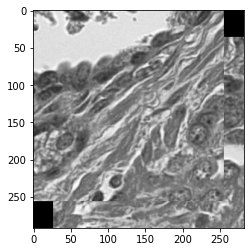

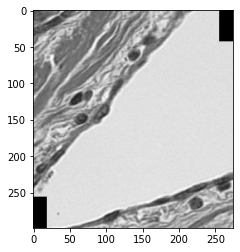

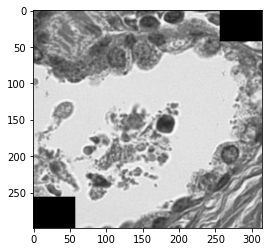

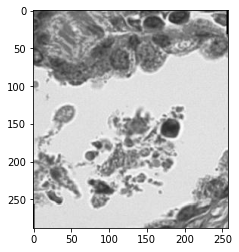

In [5]:
input_img1 = io.imread('test/input1.png')
refer_img1 = io.imread('test/refer1.png')

test_one_pair(input_img1,refer_img1,-36,-27)
input_img2 = io.imread('test/input2.png')
refer_img2 = io.imread('test/refer2.png')

test_one_pair(input_img2,refer_img2,-43,-19)

input_img3 = io.imread('test/input3.png')
refer_img3 = io.imread('test/refer3.png')

test_one_pair(input_img3,refer_img3,-43,-58)

input_img4 = io.imread('test/input4.png')
refer_img4 = io.imread('test/refer4.png')

test_one_pair(input_img4,refer_img4,-32,-2)